In [1]:
import os,subprocess
workdir='/nagyvinyok/adat84/sotejedlik/ribli/expression/prepare_data'
subprocess.call(['mkdir',workdir])
os.chdir(workdir)


import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.style.use('ggplot')
%matplotlib inline

### Filename tcga barcode mappings

In [5]:
fs_map=pd.read_csv('../data/brca_rnaseq/FILE_SAMPLE_MAP.txt',sep='\t')
#fs_map=fs_map.iloc[:-1,:]
fs_dict={}
for i in xrange(len(fs_map)):
    fs_dict[fs_map.iloc[i,0]]=fs_map.iloc[i,1]
    
    
tum_dict={}
for i in xrange(len(fs_map)):
    if ( fs_map.iloc[i,1].split('-')[3][0]=='0'):
        tum_dict[fs_map.iloc[i,0]]='tumor'
    else:
        tum_dict[fs_map.iloc[i,0]]='normal'

### Load all normal data

In [6]:
datadir='../data/brca_rnaseq/RNASeqV2/UNC__IlluminaHiSeq_RNASeqV2/Level_3/'

In [7]:
import gc
import os
from glob import glob

norm_list=[]
gene_df=pd.DataFrame()
i=0
for filename in glob(datadir+'*exon_quantification.txt'):
    fname=os.path.basename(filename)
    
    if tum_dict[fname]!='tumor':
        tmp_df=pd.read_csv(filename, sep='\t',header=0)
        gene_df=tmp_df.exon
        norm_list.append(tmp_df[['RPKM']])
        
    print '.',
    i+=1
    if i%100==0:
        print i,
    gc.collect()

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 100 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 200 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 300 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 400 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

### Create normal data matrix

In [8]:
n_data_matrix=pd.concat([gene_df]+norm_list,axis=1)

### discard the absolutely not mapped regions

In [9]:
idx=n_data_matrix.drop('exon',axis=1).mean(axis=1)!=0
print np.sum(idx)

234058


### Check mean,std

In [10]:
import seaborn as sns

/usr/local/lib/python2.7/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:1279: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:1289: UserWarning: findfont: Could not match :family=Bitstream Vera Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0. Returning /usr/share/matplotlib/mpl-data/fonts/ttf/cmb10.ttf
  UserWarning)


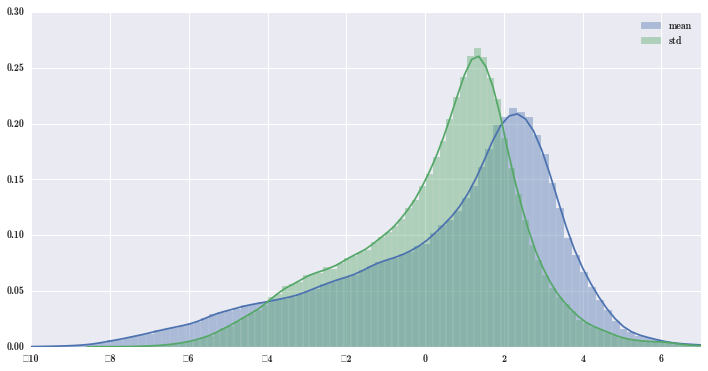

In [11]:
fig=plt.figure(figsize=(12,6))
ax=fig.add_subplot(111)
dump=sns.distplot(np.log(n_data_matrix.drop('exon',axis=1).mean(axis=1)[idx]),
                  hist=True,kde=True,bins=100,label='mean')
dump=sns.distplot(np.log(n_data_matrix.drop('exon',axis=1).std(axis=1)[idx]),
                  hist=True,kde=True,bins=100,label='std')
plt.xlim(-10,7)
dump=ax.legend()

### Create log mean rpkm dataframe

In [12]:
final_df=pd.concat([gene_df[idx],np.log(n_data_matrix.drop('exon',axis=1).mean(axis=1))[idx]],axis=1)
final_df.columns=['exon','log_mean_rpkm']

final_df['chrom']=[x.split(':')[0] for x in final_df.exon]
final_df['strand']=[x.split(':')[2] for x in final_df.exon]
final_df['start']=[int(x.split(':')[1].split('-')[0]) for x in final_df.exon]
final_df['end']=[int(x.split(':')[1].split('-')[1]) for x in final_df.exon]

final_df.head()

,exon,log_mean_rpkm,chrom,strand,start,end
0,chr1:11874-12227:+,-1.290285,chr1,+,11874,12227
1,chr1:12595-12721:+,-1.442067,chr1,+,12595,12721
2,chr1:12613-12721:+,-1.310520,chr1,+,12613,12721
3,chr1:12646-12697:+,-0.890017,chr1,+,12646,12697
4,chr1:13221-14409:+,-0.501733,chr1,+,13221,14409


#### Exclude this "chromosome"

In [13]:
idx=final_df.chrom != 'chrM_rCRS'
final_df=final_df[idx]

#### Exon lengths ?

(1, 4)

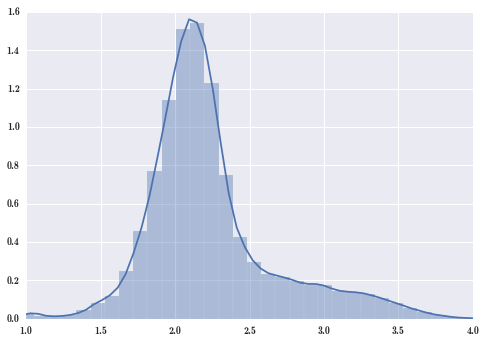

In [22]:
sns.distplot(np.log10(np.abs(1+final_df.end-final_df.start)))
plt.xlim(1,4)

## Create naive feature vectors

In [25]:
from Bio import SeqIO
from Bio.Seq import Seq
#load fasta file in one piece
ref_dict=SeqIO.to_dict(SeqIO.parse(
        '/home/ribli/input/Homo_sapiens.GRCh37.75.dna_sm.primary_assembly.fa',"fasta"))

In [33]:
def exon_to_csv(input_df,output_fname,ref_dict,plus=100,minus=100):
    """
    Create relatively small csv files from pandas df of probes.
    
    Used in naive prediction as feauture vectors.
    """

    with open(output_fname,'w') as out_f:
        for i in xrange(len(input_df)):
            try:
                out_f.write(make_naive_line(input_df.iloc[i,:],ref_dict,plus,minus))
            except ValueError,e:
                pass
                
def make_naive_line(line,ref_dict,plus,minus):
    """Transform annotation line into naive feature vector line."""
    exon,log_mean_rpkm,chrom,strand,start,end=line
    chrom=chrom[3:]
    
     #seq depending on strand
    if strand=="+":
        out_line = '\t'.join([exon]+map(base_to_num,ref_dict[chrom].seq[
                        start-minus:start+plus] + ref_dict[chrom].seq[
                        end-minus:end+plus]))
    elif strand=="-":
        out_line = '\t'.join([exon]+map(base_to_num,ref_dict[chrom].seq[
                        end-minus:end+plus].reverse_complement() +
                        ref_dict[chrom].seq[
                        start-minus:start+plus].reverse_complement()))
    
    out_line+='\t'+str(log_mean_rpkm)+'\n'
    return out_line
                

def base_to_num(base):
    """
    Return a small unique number for each base.
    
    Doing this to turn categorical data into numeric ones.
    Should be checked, if the choice of order makes difference!
    
    """

    if (base =='a' or base=='A'):
        return '1'
    if (base =='c' or base=='C'):
        return '2'
    if (base =='g' or base=='G'):
        return '3'
    if (base =='t' or base=='T'):
        return '4'
    else:
        raise ValueError('strange base in reference genom')

In [34]:
out_fname='naive_feat_vect.csv'
exon_to_csv(final_df,output_fname=out_fname,ref_dict=ref_dict,plus=100,minus=300)